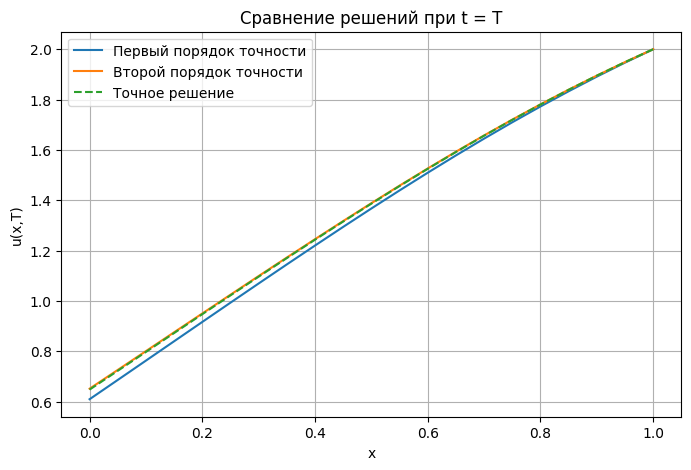

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, t):
    return 2 * x * t + (1 + np.tanh(x - t) - 2 * (np.tanh(x - t))**2) / (np.cosh(x - t))

def u_exact(x, t):
    return 1 / (np.cosh(x - t)) + x * t**2

def psi1(t):
    return t**2 + (1 + np.tanh(t)) / np.cosh(t)

def psi2(t):
    return t**2 + 1 / np.cosh(1 - t)

def nach_usl(x):
    return 1 / np.cosh(x)


def solution(N=20, h=0.05, dt=0.01, T=1.0, order=1):

    x = np.linspace(0, N*h, N+1)
    M = int(round(T/dt))
    t = np.linspace(0, T, M+1)
    U = np.zeros((N+1, M+1))

    for i in range(N+1):
        U[i,0] = nach_usl(x[i])

    alpha = dt / (2 * h * h)

    for n in range(M):
        a_local = -alpha * np.ones(N-1)
        b_local = (1 + 2*alpha) * np.ones(N-1)
        c_local = -alpha * np.ones(N-1)

        rhs = np.zeros(N-1)
        for i in range(1, N):
            f_n   = f(x[i], t[n])
            f_np1 = f(x[i], t[n+1])
            rhs[i-1] = (1 - 2*alpha)*U[i, n] + alpha*U[i-1, n] + alpha*U[i+1, n] \
                       + 0.5*dt*(f_n + f_np1)

        psi1_val = psi1(t[n+1])

        if order == 1:
            denom = 1.0 - 1.0/h
            A_ = psi1_val / denom
            B_ = (1.0/h) / denom
            rhs[0] += alpha * A_
            b_local[0] += alpha * B_

        elif order == 2:
            denom = 1.0 - 3.0/(2.0*h)
            A0 = 1.0 / denom
            B0 = 4.0/(2.0*h) / denom
            C0 = -1.0/(2.0*h) / denom
            rhs[0] += alpha * A0 * psi1_val
            b_local[0] += alpha * B0
            c_local[0] = -alpha + alpha * C0

        psi2_val = psi2(t[n+1])
        rhs[-1] -= c_local[-1] * psi2_val

        a_save = a_local.copy()
        b_save = b_local.copy()
        c_save = c_local.copy()
        rhs_save = rhs.copy()

        for i in range(1, N-1):
            w = a_save[i] / b_save[i-1]
            b_save[i] = b_save[i] - w * c_save[i-1]
            rhs_save[i] = rhs_save[i] - w * rhs_save[i-1]

        U_new = np.zeros(N-1)
        U_new[-1] = rhs_save[-1] / b_save[-1]
        for i in range(N-3, -1, -1):
            U_new[i] = (rhs_save[i] - c_save[i] * U_new[i+1]) / b_save[i]

        for i in range(1, N):
            U[i, n+1] = U_new[i-1]

        if order == 1:
            U[0, n+1] = A_ - B_ * U[1, n+1]
        else:
            U[0, n+1] = A0 * psi1_val - B0 * U[1, n+1] - C0 * U[2, n+1]

        U[N, n+1] = psi2_val

    return x, t, U

h = 0.05
N = int(1/h)
dt = 0.05
T = 1
# dt = float(input("tau: "))
# T = float(input("T: "))

x1, t1, U1 = solution(N=N, h=h, dt=dt, T=T, order=1)
x2, t2, U2 = solution(N=N, h=h, dt=dt, T=T, order=2)

X, T_grid = np.meshgrid(x1, t1, indexing='ij')
U_exact_full = u_exact(X, T_grid)

u_ex_T = u_exact(x1, T)

plt.figure(figsize=(8,5))
plt.plot(x1, U1[:, -1], label="Первый порядок точности")
plt.plot(x2, U2[:, -1], label="Второй порядок точности")
plt.plot(x1, u_ex_T, ls='--', label="Точное решение")
plt.xlabel("x")
plt.ylabel("u(x,T)")
plt.title("Сравнение решений при t = T")
plt.grid(True)
plt.legend()
plt.show()

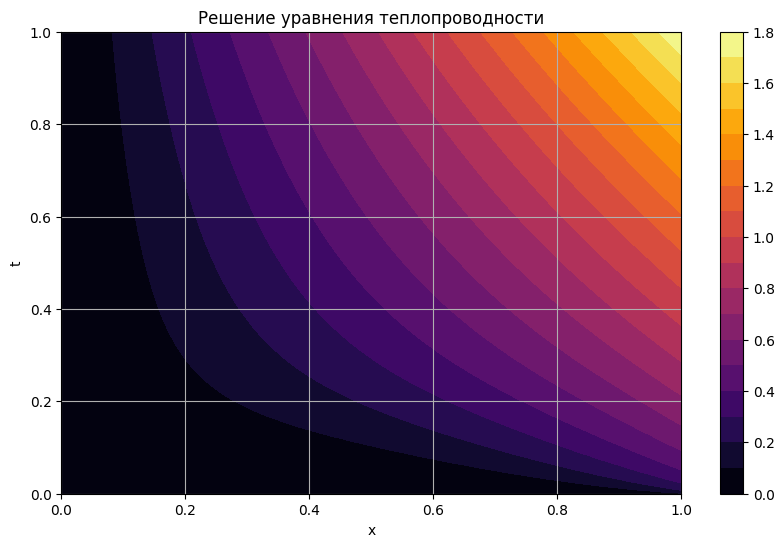

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

L = 1.0
T_max = 1.0
h = 0.05
tau = 0.001
alpha = 1.0


x = np.arange(0, L + h, h)
t = np.arange(0, T_max + tau, tau)
N = len(x)
M = len(t)


u = np.zeros((M, N))


u[0, :] = 0


for n in range(0, M - 1):

    for i in range(1, N - 1):
        u[n + 1, i] = u[n, i] + alpha * tau / h**2 * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1])

    # Граничные условия:
    # u_x(0,t) = t  → u[1] = u[0] + h * t
    u[n + 1, 1] = u[n + 1, 0] + h * t[n + 1]

    # 2u(1,t) + u_x(1,t) = 2 + 2sinh(t) + t*cosh(t)
    # → (2h + 1) * u[N-1] - u[N-2] = h * RHS
    RHS = 2 + 2 * np.sinh(t[n + 1]) + t[n + 1] * np.cosh(t[n + 1])
    u[n + 1, -1] = (h * RHS + u[n + 1, -2]) / (2 * h + 1)


X, T = np.meshgrid(x, t)
plt.figure(figsize=(10, 6))
cp = plt.contourf(X, T, u, levels=20, cmap='inferno')
plt.colorbar(cp)
plt.title("Решение уравнения теплопроводности")
plt.xlabel("x")
plt.ylabel("t")
plt.grid(True)
plt.show()


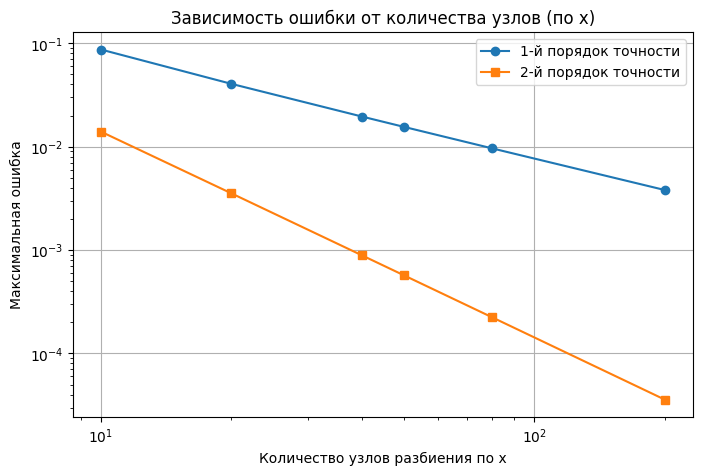

In [ ]:
hs = [0.1, 0.05, 0.025, 0.02, 0.0125, 0.005]
errors_1 = []
errors_2 = []

for h in hs:
    N = int(1/h)
    dt = h / 2  # Условие устойчивости
    x1, t1, U1 = solution(N=N, h=h, dt=dt, T=1, order=1)
    x2, t2, U2 = solution(N=N, h=h, dt=dt, T=1, order=2)

    X, T_grid = np.meshgrid(x1, t1, indexing='ij')
    U_exact_full = u_exact(X, T_grid)

    error_1 = np.max(np.abs(U1 - U_exact_full))
    error_2 = np.max(np.abs(U2 - U_exact_full))
    errors_1.append(error_1)
    errors_2.append(error_2)

plt.figure(figsize=(8,5))
plt.loglog(1/np.array(hs), errors_1, 'o-', label='1-й порядок точности')
plt.loglog(1/np.array(hs), errors_2, 's-', label='2-й порядок точности')
plt.xlabel('Количество узлов разбиения по x')
plt.ylabel('Максимальная ошибка')
plt.title('Зависимость ошибки от количества узлов (по x)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("Тангенс угла наклона первого порядка (синей линии):")
print((np.log(errors_1[0]) - np.log(errors_1[-1]))/(np.log(1/np.array(hs)[0]) - np.log(1/np.array(hs)[-1])))
print("Тангенс угла наклона второго порядка (оранжевой линии):")
print((np.log(errors_2[0]) - np.log(errors_2[-1]))/(np.log(1/np.array(hs)[0]) - np.log(1/np.array(hs)[-1])))

Тангенс угла наклона первого порядка (синей линии):
-1.0440841451393796
Тангенс угла наклона второго порядка (оранжевой линии):
-1.9912804566099638


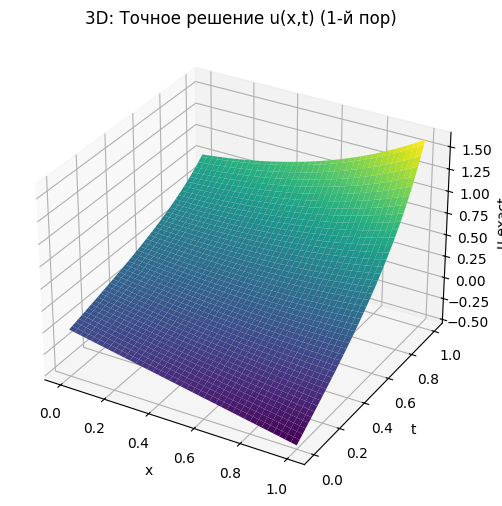

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T_grid, U_exact_full, cmap='viridis')
ax.set_title("Точное решение u(x,t) (1-й пор)")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u exact")

plt.show()